<a href="https://colab.research.google.com/github/ahmadfadhilnugraha/Megaline/blob/main/Sprint_7_Megaline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Megaline - Employing Machine Learning to Suggest Optimal Data Plans for Clients


---



## Content

* [Introduction](#introduction)
* [Data Pre-processing](#data-pre-processing)
    * [Importing Libraries, Reading, and Checking Data Files](#importing-libraries-reading-and-checking-data-files)
    * [Data Exploration](#data-exploration)
* [Data Splitting](#data-splitting)
* [Model Training](#model-training)
    * [Sanity Check](#sanity-check)
    * [Model Training - Decision Tree](#model-training-decision-tree)
    * [Model Training - Random Forest](#model-training-random-forest)
    * [Model Training - Logistic Regression](#model-training-logistic-regression)
* [Summary](#summary)


## Introduction

Megaline mobile operator feels dissatisfied because most of their customers are still using old packages. The company wants to develop a model that can analyze consumer behavior and recommend one of Megaline's two newest packages: Smart or Ultra.
I have been given access to data on the behavior of customers who have switched to the latest packages (from a previous project). In this classification task, I am asked to develop a model that can choose the package accurately. The target of the developed model is to have the highest possible accuracy level with a minimum of 0.75.

## Goal

- Developing a model capable of accurately selecting the package with a minimum accuracy level of 0.75.

## Step

1. Import and inspect the data file.
2. Split the dataset into training set, validation set, and test set.
3. Develop the model and check its quality by adjusting hyperparameters.
4. Evaluate the model's quality using the test set.
5. Perform a sanity check on the model.

## Data Description
Each observation in the dataset we have contains monthly behavioral information about one user. This information includes:
- calls: the number of calls
- minutes: total duration of calls in minutes
- messages: the number of text messages
- mb_used: internet usage traffic in MB
- is_ultimate: the package for the current month (Ultimate - 1, Surf - 0)

## 1. Data Pre-processing

### 1.1. Importing Libraries, Reading, and Checking Data Files

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tabulate import tabulate

In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/DS/SPRINT_7/users_behavior.csv')

### 1.2. Data Exploration

In [5]:
def inspect_df(df):
  print(df.info())
  display(df.head())

In [6]:
inspect_df(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [7]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


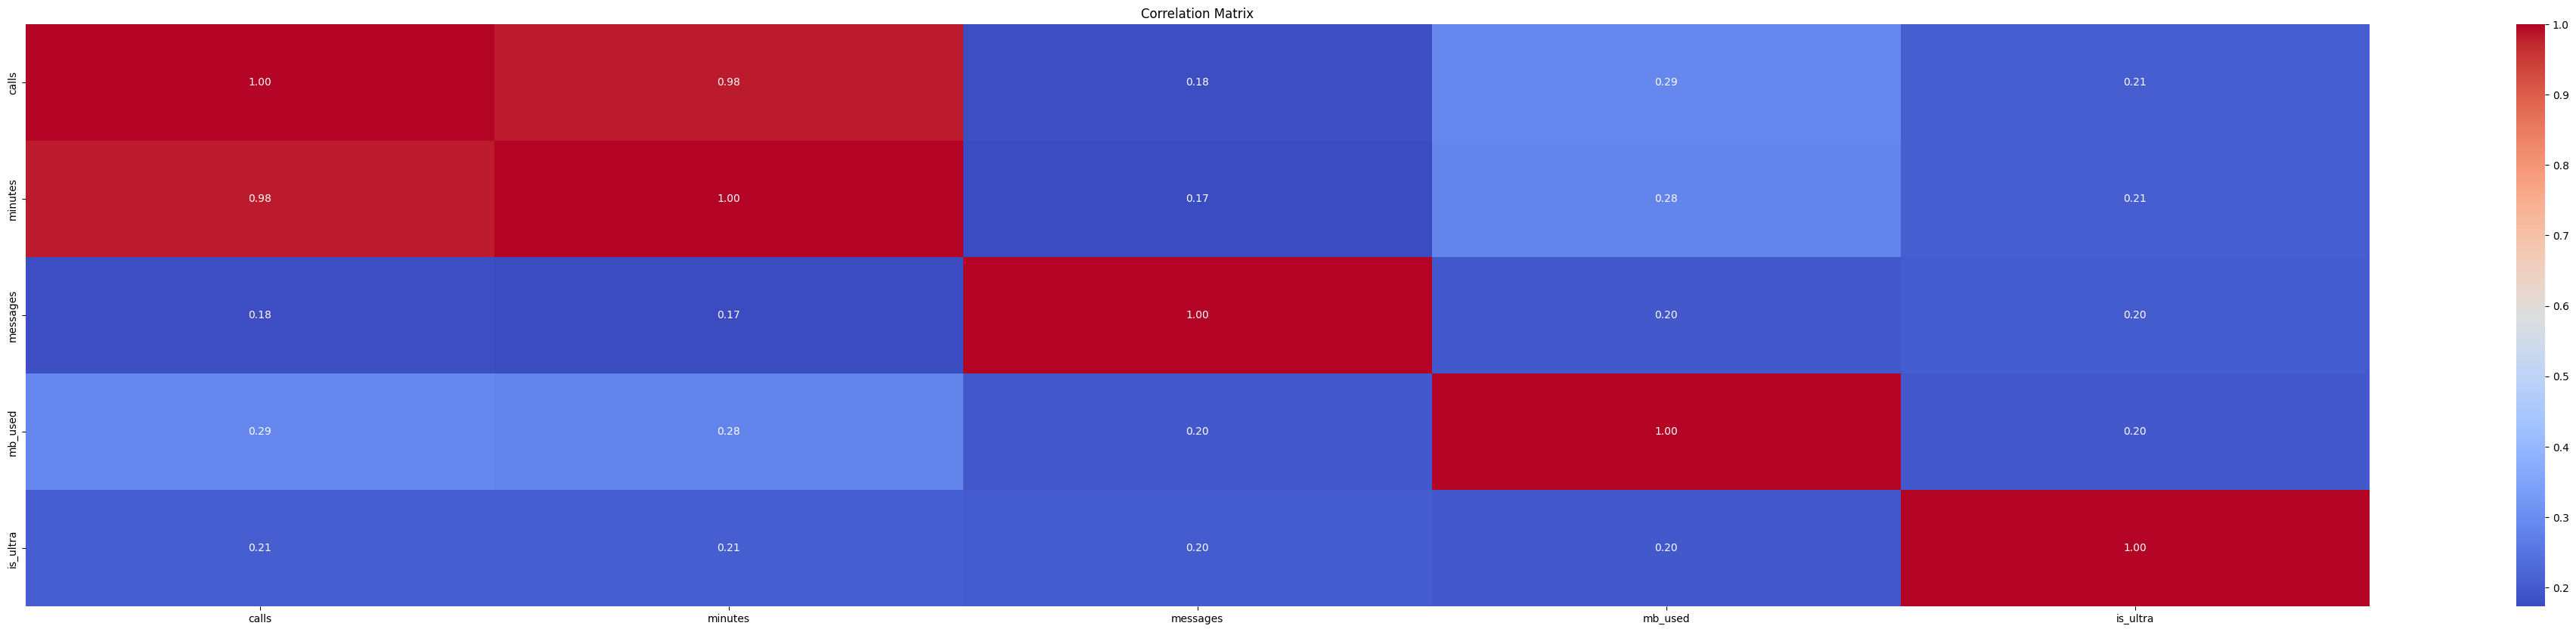

In [8]:
correlation_matrix = df.corr()
plt.figure(figsize=(50, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

We have an explored dataset and no anomalies were found in the dataset, indicating that the data can be used for model development quite effectively.

## 2. Data Splitting

In this section, we will split dataset into 3 set:
1. Training Set
2. Validation Set
3. Test Set

The column is_ultra indicates the plan used by a customer, it contains a 0 if the Smart plan is used, and a 1 if the Ultra plan is used. Since we aim to recommend a plan to customers based on their data usage habits, the column is_ultra will be our target column. And other will use for features.

In [9]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

We will split the dataset with a ratio of 3:1:1 for each dataset. (Training Set 60%, Validation Set 20% and Test Set 20%)

In [10]:
#random state value
rs = 12345

In [11]:
# first, we split 60% of dataset for training set
features_train, features_x, target_train, target_x  = train_test_split(features, target, test_size=0.4,
                                                                               random_state=rs)

In [12]:
# we split x_set with ratio 50:50 to get validation set and test set
features_valid, features_test, target_valid, target_test = train_test_split(features_x, target_x, test_size=0.5,
                                                                             random_state=rs)

In [13]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(1928, 4)
(1928,)
(643, 4)
(643,)
(643, 4)
(643,)


## 3. Model Training

In this project, I will train the model with 3 types: decision tree, random forest, and logistic regression.

### 3.1. Sanity Check

In [14]:
target_constant = df['is_ultra']
target_pred_constant = pd.Series(0, index=target.index)
constant_accuracy_test = accuracy_score(target_constant, target_pred_constant)
print("Model Accuracy on Sanity Check:", constant_accuracy_test)

Model Accuracy on Sanity Check: 0.693528313627878


### 3.2. Model Training - Decision Tree

In [15]:
# Initialize the decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=rs)

In [16]:
dt_param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

In [17]:
# Initialize GridSearchCV
dt_grid_search = GridSearchCV(dt_classifier, dt_param_grid, cv=5, scoring='accuracy')

In [18]:
# Perform grid search to find the best hyperparameters
dt_grid_search.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [19]:
dt_best_params = dt_grid_search.best_params_
print("Best Hyperparameters:", dt_best_params)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}


In [20]:
# Train the decision tree classifier
dt_classifier = dt_grid_search.best_estimator_
dt_classifier.fit(features_train, target_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       min_samples_split=5, random_state=12345)

In [21]:
# Predict the labels for the validation set
dt_val_pred = dt_classifier.predict(features_valid)

In [22]:
# Calculate the accuracy of the model on the validation set
dt_accuracy_val = accuracy_score(target_valid, dt_val_pred)
print("Decision Tree Model Accuracy on Validation Set:", dt_accuracy_val)

Decision Tree Model Accuracy on Validation Set: 0.7884914463452566


In [23]:
# Predict the labels for the test set
dt_test_pred = dt_classifier.predict(features_test)

In [24]:
# Calculate the accuracy of the model on the test set
dt_accuracy_test = accuracy_score(target_test, dt_test_pred)
print("Decision Tree Model Accuracy on Test Set:", dt_accuracy_test)

Decision Tree Model Accuracy on Test Set: 0.7900466562986003


### 3.3. Model Training - Random Forest

In [26]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=rs)

In [27]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [28]:
# Initialize GridSearchCV
rf_grid_search = GridSearchCV(rf_classifier, rf_param_grid, cv=5, scoring='accuracy')

In [29]:
# Perform grid search to find the best hyperparameters
rf_grid_search.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [30]:
rf_best_params = rf_grid_search.best_params_
print("Best Hyperparameters for Random Forest:", rf_best_params)

Best Hyperparameters for Random Forest: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


In [31]:
# Use the best hyperparameters to train the model
rf_classifier = rf_grid_search.best_estimator_
rf_classifier.fit(features_train, target_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=300,
                       random_state=12345)

In [32]:
# Predict the labels for the validation set using the best model
rf_val_pred = rf_classifier.predict(features_valid)

In [33]:
# Calculate the accuracy of the model on the validation set
rf_accuracy_val = accuracy_score(target_valid, rf_val_pred)
print("Random Forest Model Accuracy on Validation Set:", rf_accuracy_val)

Random Forest Model Accuracy on Validation Set: 0.7947122861586314


In [34]:
# Predict the labels for the test set using the best model
rf_test_pred = rf_classifier.predict(features_test)

In [35]:
# Calculate the accuracy of the model on the test set
rf_accuracy_test = accuracy_score(target_test, rf_test_pred)
print("Random Forest Model Accuracy on Test Set:", rf_accuracy_test)

Random Forest Model Accuracy on Test Set: 0.80248833592535


### 3.4. Model Training - Logistic Regression

In [37]:
# Initialize the logistic regression classifier
lr_classifier = LogisticRegression(random_state=rs)

In [38]:
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

In [39]:
# Initialize GridSearchCV
lr_grid_search = GridSearchCV(lr_classifier, lr_param_grid, cv=5, scoring='accuracy')

In [40]:
# Perform grid search to find the best hyperparameters
lr_grid_search.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=12345),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [41]:
lr_best_params = lr_grid_search.best_params_
print("Best Hyperparameters for Logistic Regression:", lr_best_params)

Best Hyperparameters for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [42]:
# Use the best hyperparameters to train the model
lr_classifier = lr_grid_search.best_estimator_
lr_classifier.fit(features_train, target_train)

LogisticRegression(C=10, penalty='l1', random_state=12345, solver='liblinear')

In [43]:
# Predict the labels for the validation set using the best model
lr_val_pred = lr_classifier.predict(features_valid)

In [44]:
# Calculate the accuracy of the model on the validation set
lr_accuracy_val = accuracy_score(target_valid, lr_val_pred)
print("Logistic Regression Model Accuracy on Validation Set:", lr_accuracy_val)

Logistic Regression Model Accuracy on Validation Set: 0.7558320373250389


In [45]:
# Predict the labels for the test set using the best model
lr_test_pred = lr_classifier.predict(features_test)

In [46]:
# Calculate the accuracy of the model on the test set
lr_accuracy_test = accuracy_score(target_test, lr_test_pred)
print("Logistic Regression Model Accuracy on Test Set:", lr_accuracy_test)

Logistic Regression Model Accuracy on Test Set: 0.7387247278382582


## 4. Summary

I have created 3 types of models for the given dataset: Decision Tree, Linear Regression, and Random Forest. The values for these three models are as follows.

In [53]:
#Summary Table
model_summary = [
    ["Model", "Accuracy on Validation Set", "Accuracy on Test Set"],
    ["Decision Tree", round(dt_accuracy_val, 4), round(dt_accuracy_test,4)],
    ["Random Forest", round(rf_accuracy_val, 4), round(rf_accuracy_test,4)],
    ["Logistic Regression", round(lr_accuracy_val, 4), round(lr_accuracy_test,4)]
]

table = tabulate(model_summary, headers="firstrow", tablefmt="pipe")
print(table)

| Model               |   Accuracy on Validation Set |   Accuracy on Test Set |
|:--------------------|-----------------------------:|-----------------------:|
| Decision Tree       |                       0.7885 |                 0.79   |
| Random Forest       |                       0.7947 |                 0.8025 |
| Logistic Regression |                       0.7558 |                 0.7387 |


Based on the provided information, the Random Forest model appears to be the most suitable choice among the three models. It achieves the highest accuracy on both the validation and test sets, indicating robust performance and generalization ability. Although there are indications of potential overfitting, its overall performance surpasses that of the Decision Tree and Logistic Regression models. Therefore, the Random Forest model is recommended for further use and deployment in this scenario.